# Visualize platemap design

Each plate has a different distribution of treatments and cell lines per well.

Visualize the following:

- Treatment x dose per well
- Cell count per well

We aim to visualizes broad trends that might be influenced by position on the plate.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(platetools))

In [2]:
# Set output files
output_dir <- "platemap_figures"

output_fig_treatment <- file.path(output_dir, "treatment_dose_platemap.png")
output_fig_cellcount <- file.path(output_dir, "cell_count_platemap.png")

In [3]:
# Load platemap files
platemap_dir <- file.path(
    "..", "3.process-cfret-features", "metadata"
)

barcode_file <- file.path(platemap_dir, "barcode_platemap_CFReT.csv")
barcode_df <- readr::read_csv(
    barcode_file, col_types = readr::cols(.default = "c")
)
barcode_df

Assay_Plate_Barcode,Plate_Map_Name
<chr>,<chr>
localhost220512140003_KK22-05-198,plate_1_CFReT
localhost220513100001_KK22-05-198_FactinAdjusted,plate_2_CFReT


In [4]:
# Focus on the FactinAdjusted plate
plate_focus <- "localhost220513100001_KK22-05-198_FactinAdjusted"

# Grab the platemap file name from the plate
platemap_name <- barcode_df %>%
    dplyr::filter(Assay_Plate_Barcode == !!plate_focus) %>%
    dplyr::pull(Plate_Map_Name)

platemap_file <- file.path(platemap_dir, paste0(platemap_name, ".csv"))
platemap_df <- readr::read_csv(
    platemap_file, col_types = readr::cols(.default = "c")
)
platemap_df <- platemap_df %>%
    dplyr::mutate(
        dose_val = as.numeric(
            stringr::str_remove(platemap_df$dose, "uM")
        )
    )
print(dim(platemap_df))
head(platemap_df, 3)

[1] 32  7


WellRow,WellCol,well_position,heart_number,treatment,dose,dose_val
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
A,9,A09,9,drug_x,5uM,5
A,10,A10,9,drug_x,10uM,10
A,11,A11,9,drug_x,10uM,10


In [5]:
# Load UMAP file to obtain cell count per well
umap_dir <- file.path("notebooks", "UMAP", "results")
umap_files <- list.files(umap_dir, full.names = TRUE)
umap_file <- umap_files[stringr::str_detect(umap_files, plate_focus)]

# Load in the umap data
umap_df <- readr::read_tsv(
    umap_file,
    col_types = readr::cols(
        .default = "d",
        "Metadata_WellRow" = "c",
        "Metadata_WellCol" = "c",
        "Metadata_heart_number" = "c",
        "Metadata_treatment" = "c",
        "Metadata_dose" = "c",
        "Metadata_ImageNumber" = "c",
        "Metadata_Plate" = "c",
        "Metadata_Well" = "c",
        "Metadata_Cytoplasm_Parent_Cells" = "c",
        "Metadata_Cytoplasm_Parent_Nuclei" = "c",
        "Metadata_Cells_Number_Object_Number" = "c",
        "Metadata_Nuclei_Number_Object_Number" = "c"
    )
)

cell_count_df <- umap_df %>%
    dplyr::group_by(Metadata_Well) %>%
    dplyr::count() %>%
    dplyr::ungroup()

head(cell_count_df)

Metadata_Well,n
<chr>,<int>
A09,342
A10,349
A11,333
A12,248
B09,459
B10,371


Warning message:
“Warning: Your well label count ( 32 ) covers less than half the selected plate( 96 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”


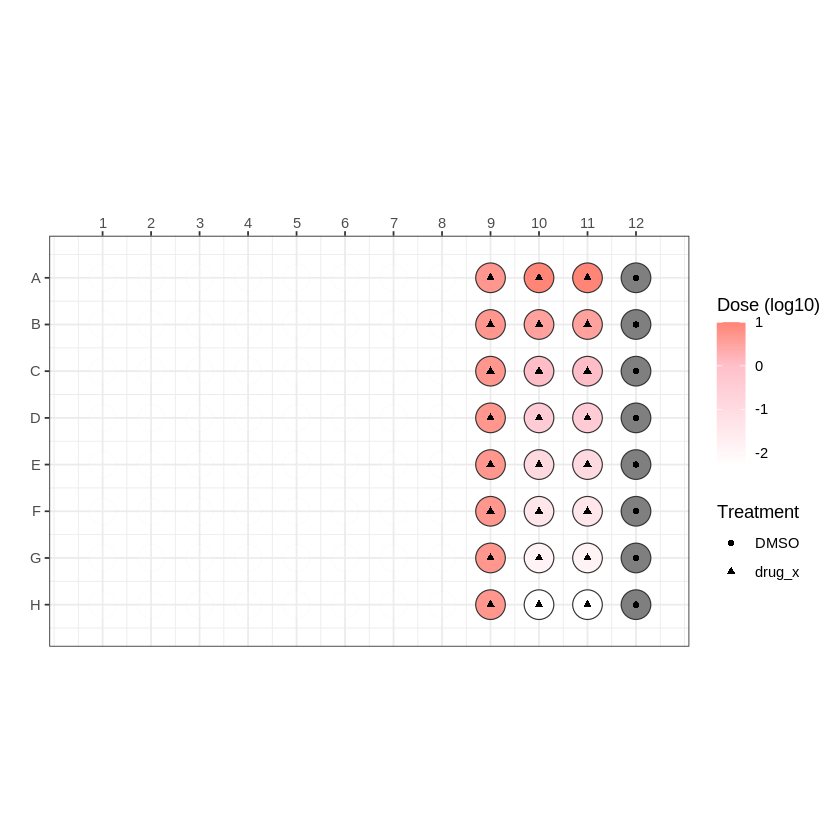

In [6]:
plate_replicate_gg <-
    platetools::raw_map(
        data = log10(platemap_df$dose_val),
        well = platemap_df$well_position,
        plate = 96,
        size = 8
    ) +
    ggplot2::geom_point(aes(shape = platemap_df$treatment)) +
    ggplot2::scale_shape_discrete(name = "Treatment") +
    ggplot2::scale_fill_gradient2(
        name = "Dose (log10)",
        low = "white",
        mid = "pink",
        high = "red",
        midpoint = 0
    )

ggsave(
    output_fig_treatment,
    plate_replicate_gg,
    dpi = 500,
    height = 3.5,
    width = 6
)

plate_replicate_gg

Warning message:
“Warning: Your well label count ( 32 ) covers less than half the selected plate( 96 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”


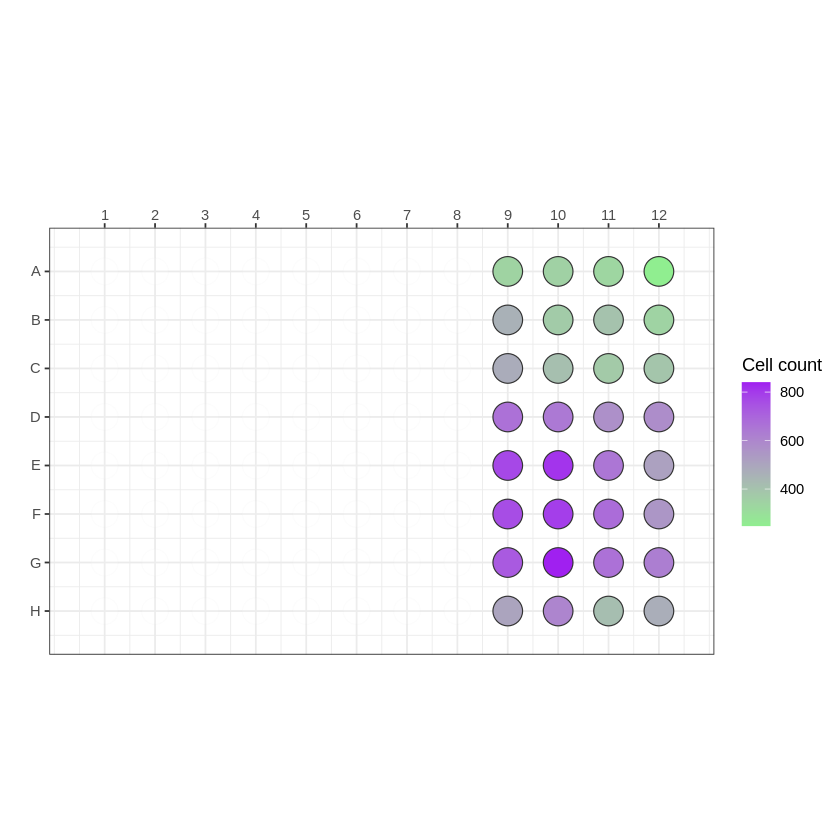

In [7]:
plate_cell_count_gg <-
    platetools::raw_map(
        data = cell_count_df$n,
        well = cell_count_df$Metadata_Well,
        plate = 96,
        size = 8
    ) +
    ggplot2::scale_fill_gradient(
        name = "Cell count",
        low = "lightgreen",
        high = "purple"
    )

ggsave(
    output_fig_cellcount,
    plate_cell_count_gg,
    dpi = 500,
    height = 3.5,
    width = 6
)

plate_cell_count_gg